<a href="https://colab.research.google.com/github/vkaramanis/Coursera_Capstone/blob/main/Segmenting_and_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
!pip install geocoder

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import geocoder
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Task 1

Fetch Data from wiki

In [ ]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')

Create table

In [ ]:
table = soup.find("table")

parsed_data = []
for row in table.findAll('tr'):
  for td in row.findAll('td'):
    data = td.get_text(separator=" ", strip=True).split("(")
    po = np.nan
    borough = np.nan
    neighborhood = np.nan

    for idx, d in enumerate(data):
      if idx == 0:
        po = d[:3]
        borough = np.nan if re.search('Not assigned',d[3:]) else d[3:]
      elif idx == 1:
        neighborhood = re.sub(r' / ', ', ', d)
        neighborhood = re.sub(r'\)*', '', neighborhood)
      else:
        clean = re.sub(r' / ', ', ', d)
        clean = re.sub(r'\)*', '', clean)
        neighborhood += ', ' + clean
    parsed_data += [[po, borough,neighborhood]]

df = pd.DataFrame(parsed_data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df.set_index('PostalCode', inplace=True)
df.head()

,Borough,Neighborhood
PostalCode,,
M1A,NaN,NaN
M2A,NaN,NaN
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop null Boroughs

In [ ]:
df = df[df['Borough'].notnull()]
df.head()

,Borough,Neighborhood
PostalCode,,
M3A,North York,Parkwoods
M4A,North York,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights"
M7A,Queen's Park,Ontario Provincial Government


There are no null Neighbourhoods

In [ ]:
df['Neighborhood'].isnull().unique()

array([False])

Shape of dataframe

In [ ]:
df.shape

(103, 2)

# Task 2

Fetch the dataset

In [ ]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

--2021-07-27 13:14:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788 (2.7K) [text/csv]
Saving to: ‘Geospatial_Coordinates.csv.2’

Geospatial_Coordina 100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-07-27 13:14:57 (429 MB/s) - ‘Geospatial_Coordinates.csv.2’ saved [2788/2788]



In [ ]:
coordinates = pd.read_csv('/content/Geospatial_Coordinates.csv')

df = df.merge(coordinates, left_on='PostalCode', right_on='Postal Code')
df = df.drop('Postal Code', 1)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


Join it with our dataset

# Task 3

In [ ]:
map_newyork = folium.Map(location=[43.651070, -79.347015], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [ ]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'],
                                 radius=700)

 Parkwoods 
 Victoria Village 
 Regent Park, Harbourfront 
 Lawrence Manor, Lawrence Heights 
Ontario Provincial Government
 Islington Avenue 
 Malvern, Rouge 
 Don Mills  North
 Parkview Hill, Woodbine Gardens 
 Garden District , Ryerson 
Glencairn
 West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
 Rouge Hill, Port Union, Highland Creek 
 Don Mills  South ,  Flemingdon Park 
 Woodbine Heights 
 St. James Town 
 Humewood-Cedarvale 
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood 
 Guildwood, Morningside, West Hill 
 The Beaches 
Berczy Park
 Caledonia-Fairbanks 
 Woburn 
 Leaside 
Central Bay Street 
Christie
 Cedarbrae 
 Hillcrest Village 
 Bathurst Manor, Wilson Heights, Downsview North
 Thorncliffe Park 
 Richmond, Adelaide, King 
 Dufferin, Dovercourt Village 
 Scarborough Village 
Fairview, Henry Farm, Oriole
 Northwood Park, York University 
 The Danforth East
 Harbourfront East, Union Station, Toronto Islands 
 Little Portugal, Trinity 
 Kenne

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

(3364, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,PetSmart,43.748639,-79.333488,Pet Store
2,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
3,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
4,Parkwoods,43.753259,-79.329656,Ranchdale Park,43.751388,-79.322138,Park


In [ ]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,9,9,9,9,9,9
"Alderwood, Long Branch",11,11,11,11,11,11
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,9,9,9,9,9,9
"Bedford Park, Lawrence Manor East",31,31,31,31,31,31
...,...,...,...,...,...,...
Ontario Provincial Government,62,62,62,62,62,62
Roselawn,4,4,4,4,4,4
Studio District,75,75,75,75,75,75


In [ ]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 324 uniques categories.


In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
columns = list(toronto_onehot.columns)
columns.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + columns
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,...,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,...,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Syrian Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.086957,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.043478,0.0,0.043478,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.032258,0.032258,0.032258,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.032258,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.032258,0.000000,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Ontario Provincial Government,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.016129,0.000000,0.016129,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.032258,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                       venue  freq
0            Motorcycle Shop  0.11
1                Coffee Shop  0.11
2  Latin American Restaurant  0.11
3            Badminton Court  0.11
4             Clothing Store  0.11


---- Alderwood, Long Branch ----
               venue  freq
0  Convenience Store  0.18
1        Pizza Place  0.18
2       Dance Studio  0.09
3        Coffee Shop  0.09
4     Sandwich Place  0.09


---- Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0  Coffee Shop  0.09
1         Bank  0.09
2         Park  0.09
3  Bridal Shop  0.04
4  Gas Station  0.04


---- Bayview Village ----
                 venue  freq
0                 Bank  0.22
1  Japanese Restaurant  0.11
2                 Café  0.11
3   Chinese Restaurant  0.11
4           Playground  0.11


---- Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.10
1         Coffee Shop  0.10
2      Sandwich Place  0.06
3                Café  0.03
4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


          venue  freq
0  Hockey Arena   0.2
1         Field   0.2
2  Tennis Court   0.2
3    Playground   0.2
4         Trail   0.2


---- India Bazaar, The Beaches West----
                  venue  freq
0     Indian Restaurant  0.07
1            Restaurant  0.04
2                   Gym  0.04
3  Fast Food Restaurant  0.04
4        Sandwich Place  0.04


---- Islington Avenue ----
          venue  freq
0      Pharmacy  0.22
1          Café  0.11
2          Bank  0.11
3  Skating Rink  0.11
4    Playground  0.11


---- Kennedy Park, Ionview, East Birchmount Park ----
               venue  freq
0        Coffee Shop  0.18
1  Convenience Store  0.09
2       Intersection  0.09
3        Bus Station  0.09
4     Sandwich Place  0.09


---- Kensington Market, Chinatown, Grange Park ----
                           venue  freq
0                           Café  0.09
1                            Bar  0.08
2  Vegetarian / Vegan Restaurant  0.06
3                    Coffee Shop  0.03
4           Caribb

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Pool Hall,Badminton Court,Latin American Restaurant,Breakfast Spot,Motorcycle Shop,Newsagent,Coffee Shop,Clothing Store,Lounge,Dumpling Restaurant
1,"Alderwood, Long Branch",Convenience Store,Pizza Place,Pool,Gym,Gas Station,Dance Studio,Sandwich Place,Coffee Shop,Pub,Drugstore
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Pizza Place,Restaurant,Bridal Shop,Supermarket,Sushi Restaurant,Shopping Mall,Sandwich Place
3,Bayview Village,Bank,Café,Skating Rink,Playground,Japanese Restaurant,Grocery Store,Chinese Restaurant,Intersection,Dive Bar,Dog Run
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Hobby Shop,Toy / Game Store,Fast Food Restaurant,Butcher,Café,Liquor Store,Sushi Restaurant


In [ ]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

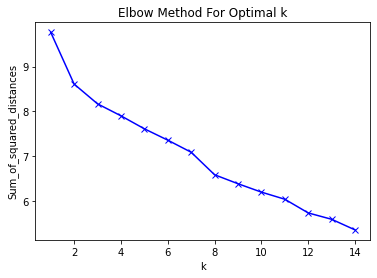

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Fast Food Restaurant,Food & Drink Shop,Pet Store,Yoga Studio,Dry Cleaner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,Hockey Arena,Playground,Coffee Shop,Pizza Place,Park,Dry Cleaner,Distribution Center,Dive Bar,Dog Run
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Restaurant,Café,Theater,Pub,Bakery,Breakfast Spot,Thai Restaurant,Performing Arts Venue
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Fast Food Restaurant,Vietnamese Restaurant,Coffee Shop,Bowling Alley,Discount Store,Dessert Shop,Athletics & Sports,Cheese Shop
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Burrito Place,Café,Park,Mexican Restaurant,Gym


In [ ]:
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [ ]:
# create map
map_clusters = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Humewood-Cedarvale,Field,Tennis Court,Hockey Arena,Playground,Trail,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
101,"Old Mill South, King's Mill Park, Sunnylea, H...",Playground,Baseball Field,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant


In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Portuguese Restaurant,Hockey Arena,Playground,Coffee Shop,Pizza Place,Park,Dry Cleaner,Distribution Center,Dive Bar,Dog Run
2,"Regent Park, Harbourfront",Coffee Shop,Park,Restaurant,Café,Theater,Pub,Bakery,Breakfast Spot,Thai Restaurant,Performing Arts Venue
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Furniture / Home Store,Fast Food Restaurant,Vietnamese Restaurant,Coffee Shop,Bowling Alley,Discount Store,Dessert Shop,Athletics & Sports,Cheese Shop
4,Ontario Provincial Government,Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Burrito Place,Café,Park,Mexican Restaurant,Gym
5,Islington Avenue,Pharmacy,Café,Park,Playground,Shopping Mall,Bank,Grocery Store,Skating Rink,Distribution Center,Dive Bar
...,...,...,...,...,...,...,...,...,...,...,...
97,"First Canadian Place, Underground city",Hotel,Coffee Shop,Café,Restaurant,Theater,Gym,Asian Restaurant,Seafood Restaurant,Bakery,Japanese Restaurant
98,"The Kingsway, Montgomery Road, Old Mill North",Park,Breakfast Spot,Bank,Sushi Restaurant,Bakery,Dessert Shop,Liquor Store,Burger Joint,Pub,Smoke Shop
99,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Yoga Studio,Men's Store,Sandwich Place,Thai Restaurant,Diner
100,Enclave of M4L,Fast Food Restaurant,Coffee Shop,Light Rail Station,Brewery,Burrito Place,Restaurant,Harbor / Marina,Yoga Studio,Beer Store,Steakhouse


In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Fast Food Restaurant,Food & Drink Shop,Pet Store,Yoga Studio,Dry Cleaner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
21,Caledonia-Fairbanks,Park,Mexican Restaurant,Gym,Beer Store,Bakery,Japanese Restaurant,Grocery Store,Sporting Goods Shop,Women's Store,Creperie
22,Woburn,Park,Coffee Shop,Business Service,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
49,"North Park, Maple Leaf Park, Upwood Park",Business Service,Construction & Landscaping,Bakery,Park,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner
52,"Willowdale, Newtonbrook",Park,Coffee Shop,Pizza Place,Trail,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
61,Lawrence Park,Business Service,Bus Line,Swim School,Park,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
66,York Mills West,Park,Pet Store,Bowling Alley,Convenience Store,Intersection,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Drugstore
83,"Moore Park, Summerhill East",Park,Thai Restaurant,Tennis Court,Gym,Grocery Store,Dry Cleaner,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
91,Rosedale,Park,Playground,Trail,Yoga Studio,Dry Cleaner,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
